In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
# !mamba install xmovie -y
# !pip install -e ../ocetrac/

## Notes
- This dataset is just **barely** fitting into memory on a large server. This should run better once we can compute out of memory with ocetrac. 

## Future Steps

- [ ] Use the higher temp resolution, currently this only works with monthly data
    - How to remove the damn climatology...resample to days before and then remove?

In [1]:
import xarray as xr
import numpy as np
import xesmf as xe
import matplotlib.pyplot as plt

In [2]:
def remove_clim(ds):
    clim = ds.groupby('time.month').mean()
    
    with ProgressBar():
        clim = clim.load()
        
    ds_anomaly = (ds.groupby('time.month') - clim)
    clim_std = ds_anomaly.groupby('time.month').std()
    with ProgressBar():
        clim_std = clim_std.load()
    return ds_anomaly.groupby('time.month') / clim_std

In [5]:
from dask.diagnostics import ProgressBar

We might want to replace this with the cloud data if available?

In [4]:
# path = 'https://thredds.jpl.nasa.gov/thredds/dodsC/ncml_aggregation/SalinityDensity/smap/aggregate__SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V4.ncml'
path = 'https://thredds.jpl.nasa.gov/thredds/dodsC/ncml_aggregation/SalinityDensity/smap/aggregate__SMAP_RSS_L3_SSS_SMI_MONTHLY_V4.ncml'
ds_smap = xr.open_dataset(path, use_cftime=True, chunks={'times':12}).rename({'times':'time', 'sss_smap':'SSS'})
ds_smap = ds_smap.assign_coords(time=xr.cftime_range(str(ds_smap.time[0].data), periods=len(ds_smap.time), freq='1MS'))
ds_smap

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, time: 72)
Coordinates:
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * lat                   (lat) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * time                  (time) object 2015-05-01 00:00:00 ... 2021-04-01 00...
Data variables:
    nobs                  (time, lat, lon) float64 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    SSS                   (time, lat, lon) float32 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    sss_ref               (time, lat, lon) float32 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    gland                 (time, lat, lon) float32 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    gice                  (time, lat, lon) float32 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    surtep                (time, lat, lon) float32 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    nobs_40km             (time, lat, lon) float64 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    sss_smap_40km         (time, lat, lon) float32 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    fland                 (time, lat, lon) float32 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    sss_smap_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
Attributes: (12/64)
    Conventions:                                    CF-1.6, ACDD-1.3
    standard_name_vocabulary:                       CF Standard Name Table v27
    title:                                          SMAP ocean surface salinity
    version:                                        V4.0 Validated Release
    processing_level:                               L3
    resolution:                                     Spatial resolution: appro...
    ...                                             ...
    Source_of_ancillary_land_mask:                  1 km land/water mask from...
    start_date:                                     2015-04-01 UTC
    start_time:                                     00:00:00 UTC
    stop_date:                                      2021-04-30 UTC
    stop_time:                                      23:59:59 UTC
    EXTRA_DIMENSION.time:                           1

I deactivated this here, because I was not happy with the 'stiched' dataset, even when I normalized both and then concatenated them, there was a distinct boundary between the datasets. You can just uncomment the below to see what I mean.

In [7]:
# # Aquarius data
# path = 'https://thredds.jpl.nasa.gov/thredds/dodsC/ncml_aggregation/SalinityDensity/aquarius/aggregate__AQUARIUS_L3_SSS_SMI_MONTHLY_V5.ncml'
# ds_aquarius = xr.open_dataset(path, use_cftime=True, chunks={'time':12}).sel(time=slice(None, '2015-04-01'))
# ds_aquarius = ds_aquarius.assign_coords(time=xr.cftime_range(str(ds_aquarius.time[0].data), periods=len(ds_aquarius.time), freq='1MS'))
# ds_aquarius

In [8]:
# bins = np.linspace(30, 39, 200)
# ds_aquarius.SSS.plot.hist(bins=bins, density=True, alpha=0.5)
# ds_smap.SSS.plot.hist(bins=bins, density=True, alpha=0.5)

In [9]:
ds_test = remove_clim(ds_smap)

[#######                                 ] | 19% Completed | 17.6s

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min 51.2s
[#######                                 ] | 17% Completed | 25.2s

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  2min 12.4s


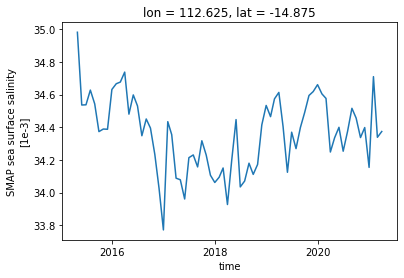

In [10]:
roi = dict(lon=450, lat=300)
ds_smap.isel(**roi).SSS.plot()

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


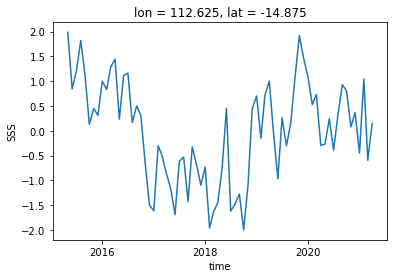

In [11]:
ds_test.isel(**roi).SSS.plot()

## Remove climatology separately

In [12]:
ds_smap_anomaly = remove_clim(ds_smap)
# ds_aquarius_anomaly = remove_clim(ds_aquarius)

[#######                                 ] | 18% Completed | 19.7s

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min 40.6s
[#######                                 ] | 17% Completed | 18.1s

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min 31.7s


# merge both datasets (currently only taking SMAP)

In [13]:
# regridder = xe.Regridder(ds_aquarius.SSS, ds_smap.SSS, method='bilinear', periodic=True)
# ds = xr.concat([regridder(ds_aquarius.SSS).chunk({'lon':-1, 'lat':-1}), ds_smap.SSS], 'time')
ds = ds_smap
ds

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, time: 72)
Coordinates:
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * lat                   (lat) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * time                  (time) object 2015-05-01 00:00:00 ... 2021-04-01 00...
Data variables:
    nobs                  (time, lat, lon) float64 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    SSS                   (time, lat, lon) float32 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    sss_ref               (time, lat, lon) float32 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    gland                 (time, lat, lon) float32 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    gice                  (time, lat, lon) float32 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    surtep                (time, lat, lon) float32 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    nobs_40km             (time, lat, lon) float64 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    sss_smap_40km         (time, lat, lon) float32 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    fland                 (time, lat, lon) float32 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    sss_smap_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:                                    CF-1.6, ACDD-1.3
    standard_name_vocabulary:                       CF Standard Name Table v27
    title:                                          SMAP ocean surface salinity
    version:                                        V4.0 Validated Release
    processing_level:                               L3
    resolution:                                     Spatial resolution: appro...
    history:                                        created by T. Meissner
    date_created:                                   2019-10-12 T10:33:24-0700
    date_modified:                                  2019-10-12 T10:33:24-0700
    institution:                                    Remote Sensing Systems, S...
    source:                                         RSS SMAP-SSS v4.0 algorithm
    platform:                                       SMAP
    instrument:                                     SMAP radiometer
    project:                                        NASA Salinity
    keywords:                                       SURFACE SALINITY, SALINIT...
    keywords_vocabulary:                            NASA Global Change Master...
    creator_name:                                   Thomas Meissner, Remote S...
    creator_email:                                  meissner@remss.com
    creator_url:                                    http://www.remss.com/miss...
    publisher_name:                                 Thomas Meissner, Frank We...
    publisher_email:                                meissner@remss.com
    publisher_url:                                  http://www.remss.com/miss...
    ID:                                             10.5067/SMP40-3SMCS
    naming_authority:                               gov.nasa.earthdata
    dataset_citation_authors:                       T. Meissner, F. Wentz, A....
    dataset_citation_year:                          2019
    dataset_citation_product:                       Remote Sensing Systems SM...
    dataset_citation_version:                       V4.0 Validated Release
    dataset_citation_institution:                   Remote Sensing Systems, S...
    dataset_citation_url:                           Available online at www.r...
    netCDF_version_id:                              4
    year_of_observation:                            2019
    month_of_observation:                           9
    center_day_of_observation:                      258
    first_orbit:                                    24475
    last_orbit:                                     24913


In [14]:
# regridder = xe.Regridder(ds_aquarius_anomaly.SSS, ds_smap_anomaly.SSS, method='bilinear', periodic=True)
# ds_anomaly = xr.concat([regridder(ds_aquarius_anomaly.SSS).chunk({'lon':-1, 'lat':-1}), ds_smap_anomaly.SSS], 'time')
ds_anomaly = ds_smap_anomaly
ds_anomaly

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, time: 72)
Coordinates:
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * lat                   (lat) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * time                  (time) object 2015-05-01 00:00:00 ... 2021-04-01 00...
    month                 (time) int64 5 6 7 8 9 10 11 12 ... 9 10 11 12 1 2 3 4
Data variables:
    nobs                  (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    SSS                   (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sss_ref               (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    gland                 (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    gice                  (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    surtep                (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs_40km             (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sss_smap_40km         (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    fland                 (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sss_smap_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

In [15]:
sss_anomaly = ds_anomaly.SSS
sss_anomaly

<xarray.DataArray 'SSS' (time: 72, lat: 720, lon: 1440)>
dask.array<getitem, shape=(72, 720, 1440), dtype=float32, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * time     (time) object 2015-05-01 00:00:00 ... 2021-04-01 00:00:00
    month    (time) int64 5 6 7 8 9 10 11 12 1 2 3 ... 6 7 8 9 10 11 12 1 2 3 4

## Create mask

[########################################] | 100% Completed |  0.2s


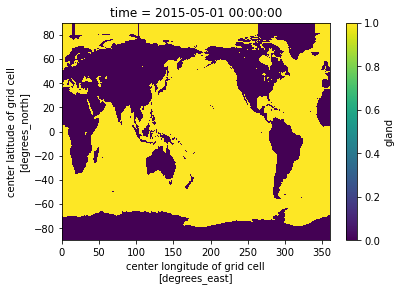

In [16]:
# mask = ds.land_fraction.sum('times') <= 0
# dummy for just the first time step
# mask = ds.land_fraction.isel(times=0) <= 0
mask = ds_smap.gland.isel(time=0) <= 0.2
with ProgressBar():
    mask = mask.load()
mask.plot()

In [17]:
sss_anomaly.nbytes/1e9

0.2985984

In [18]:
# with ProgressBar():
#     sss_anomaly = sss_anomaly.load()

In [19]:
!cat /proc/meminfo | grep Mem

MemTotal:       26698836 kB
MemFree:        12184968 kB
MemAvailable:   20590016 kB


## Thresholding the SSS

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


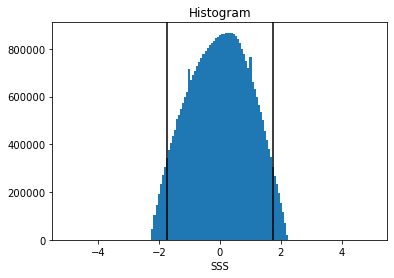

In [20]:
sss_anomaly.plot.hist(bins=np.linspace(-5,5, 150));
th = 1.75 # in std
plt.axvline(th, color='k')
plt.axvline(-th, color='k')
# for now just take 0.5 as a threshold

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


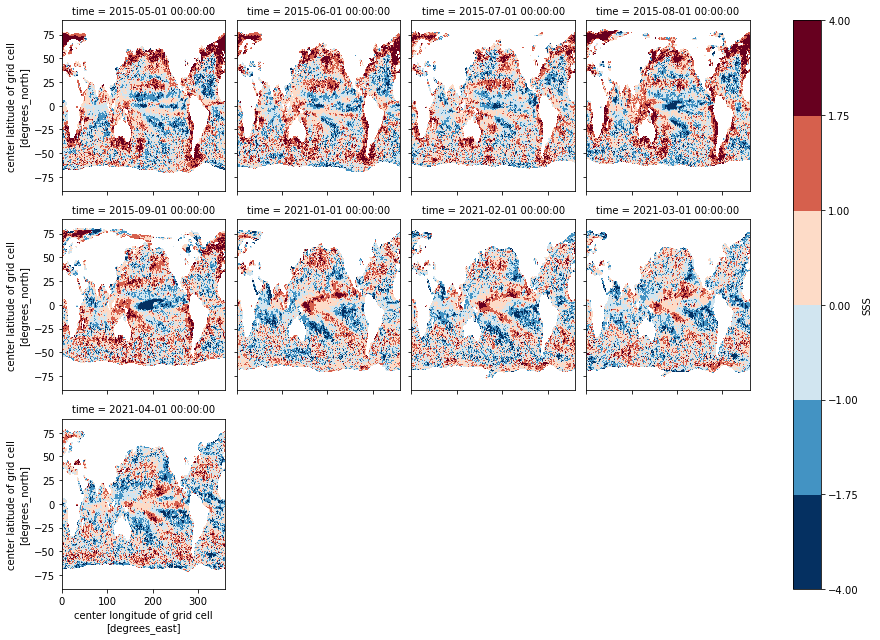

In [21]:
da = sss_anomaly.isel(time=[0,1,2,3,4,-4,-3,-2,-1])
da.plot(col='time', col_wrap=4, robust=True, levels=[-4, -th, -1, 0, 1, th, 4])

In [22]:
# sss_anomaly.quantile(0.9)

In [23]:
sss_binary_positive = sss_anomaly.where(sss_anomaly>=th, 0)
sss_binary_positive = sss_binary_positive.where(sss_binary_positive<th, 1)

sss_binary_negative = sss_anomaly.where(sss_anomaly<=-th, 0)
sss_binary_negative = sss_binary_negative.where(sss_binary_negative>-th, 1)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


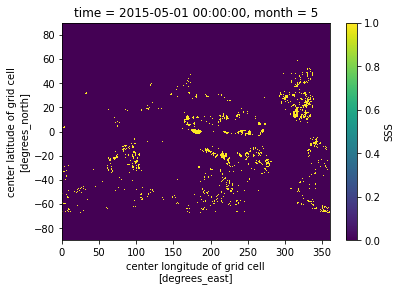

In [24]:
sss_binary_negative.isel(time=0).plot()

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


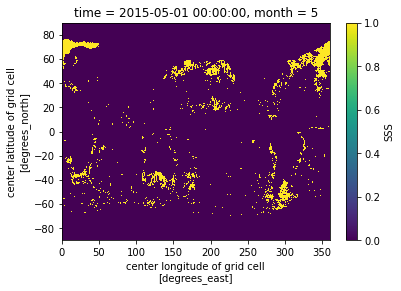

In [25]:
sss_binary_positive.isel(time=0).plot()

## Ocetrac Magic 🦄

In [26]:
from ocetrac.track import track

with ProgressBar():
    labels_negative = track(sss_binary_negative, mask, radius=10, min_size_quartile=0.75)
    labels_positive = track(sss_binary_positive, mask, radius=10, min_size_quartile=0.75)

[                                        ] | 0% Completed |  1.7s

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 33.5s
minimum area:  1848.0
inital objects identified 	 1791
final objects tracked 	 193
[                                        ] | 0% Completed |  2.6s

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 34.7s
minimum area:  2013.75
inital objects identified 	 1530
final objects tracked 	 158


In [27]:
ds_movie = xr.Dataset({'positive':labels_positive, 'negative':labels_negative, 'SSS':ds.SSS})
ds_movie

<xarray.Dataset>
Dimensions:   (lat: 720, lon: 1440, time: 72)
Coordinates:
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * lat       (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * time      (time) object 2015-05-01 00:00:00 ... 2021-04-01 00:00:00
    month     (time) int64 5 6 7 8 9 10 11 12 1 2 3 ... 6 7 8 9 10 11 12 1 2 3 4
Data variables:
    positive  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    negative  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    SSS       (time, lat, lon) float32 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>

## Movie time 

In [28]:
from xarrayutils.plotting import map_util_plot
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo

In [29]:
def custom_plotfunc(ds, fig, tt, framedim='time', **kwargs):
    ax = fig.subplots(subplot_kw=dict(projection=ccrs.Robinson(205)))
    ds_frame = ds.isel({framedim:tt})
    pp0 = ds_frame.SSS.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=31, vmax=38, cmap=cmo.haline)
    pp1 = (ds_frame.positive > 0).plot.contour(ax=ax, transform=ccrs.PlateCarree(),levels=[0.5], colors=['r'],  **kwargs)
    pp2 = (ds_frame.negative > 0).plot.contour(ax=ax, transform=ccrs.PlateCarree(),levels=[0.5], colors=['b'],  **kwargs)
    map_util_plot(ax)
    return ax, [pp1, pp2] 

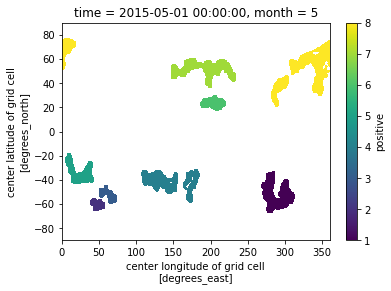

In [30]:
ds_movie.positive.isel(time=0).plot()

(<GeoAxesSubplot:title={'center':'time = 2015-08-01 00:00:00, month = 8'}, xlabel='center longitude of grid cell\n[degrees_east]', ylabel='center latitude of grid cell\n[degrees_north]'>,
  <cartopy.mpl.contour.GeoContourSet at 0x7fd2883e1b80>])

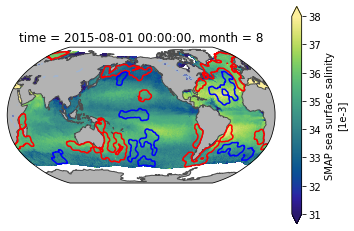

In [31]:
fig = plt.figure()
custom_plotfunc(ds_movie, fig, 3)

In [32]:
ds_movie = ds_movie.chunk({'time':1})
ds_movie = ds_movie.resample(time='5D').interpolate("linear")

In [ ]:
from xmovie import Movie
from xmovie.presets import _add_land

mov = Movie(ds_movie, framedim='time', plotfunc=custom_plotfunc, input_check=False)

In [ ]:
mov.preview(-2)

In [ ]:
mov.preview(-3)

In [ ]:
mov.preview(30)

In [44]:
mov.save(
    'ocetrac_sss_smap_aquarius_full_contour.mp4',
    progress=True, 
    overwrite_existing=True
#         progress=False,
#         parallel=True,
#         parallel_compute_kwargs={
#             'scheduler':'processes',
#             'num_workers':2
#         }
)

  0%|          | 0/116 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = ma

Movie created at ocetrac_sss_smap_aquarius_full_contour.mp4
